# Harvest BTAA Geoportals

> Original created on Dec 16 2020 <br>
Edited on Jan 28 2021 -- Converted GeoJSON into TopoJSON to reduce file size<br>
@author: Yijing Zhou @YijingZhou33 

## Part 0: Initialization

### Import necessary modules

In [1]:
import os
import pandas as pd
import json
import numpy as np
import re
from bs4 import BeautifulSoup, SoupStrainer
import requests
import geopandas as gpd
import folium

Note that **<a href='https://pypi.org/project/mapclassify/'>mapclassify</a>**, **<a href='https://seaborn.pydata.org/'>seaborn</a>** and **<a href='https://mattijn.github.io/topojson/'>topojson</a>** aren't built-in modules in Anaconda. You may need to install in advance. 

In [2]:
# pip install mapclassify 
# pip install seaborn
# pip install topojson
import mapclassify 
import seaborn as sns 
import topojson as tp

### Set file path

In [3]:
# ********** Input Files **********
## Raw data: CSV files
stategeoportals = os.path.join('data', 'allStates.csv')
countygeoportals = os.path.join('data', 'allCounties.csv')
citygeoportals = os.path.join('data', 'allCities.csv')

## Basemap GeoJSON files for states and counties 
statejson = os.path.join('data', 'states.json')
countyjson = os.path.join('data', 'counties.json')

# ********** Output Files **********
activestates = os.path.join('json', 'activeStates.topo.json')
activecounties = os.path.join('json', 'activeCounties.topo.json')
activecities = os.path.join('json', 'activeCities.json')

legendjson = os.path.join('json', 'legend.json')

***

## Part 1: State Geoportals TopoJSON

### Format state name in state geoportals spreadsheet `allStates.csv`

In [4]:
df_csv = pd.read_csv(stategeoportals)
df_csv['btaaURL'] = df_csv['btaaURL'].apply(lambda x: x.split('-')[0])
df_csv.head()

,stateCode,State,Title,sourceURL,btaaURL
0,8856ec9a-47ac-4c79-bfba-643e97c0b62d,Pennsylvania,Center for Rural Pennsylvania Data Downloads,https://www.rural.pa.gov/home,https://geo.btaa.org/?q=8856ec9a
1,03a-06,Iowa,Election Data: Iowa,https://sos.iowa.gov/elections/otherinfo.html,https://geo.btaa.org/?q=03a
2,11a-01,Ohio,GEOhio Spatial Data Discovery Portal,http://ogrip-geohio.opendata.arcgis.com,https://geo.btaa.org/?q=11a
3,01d-02,Indiana,Indiana Spatial Data Portal,http://gis.iu.edu,https://geo.btaa.org/?q=01d
4,09a-02,Indiana,Indiana Statewide LiDAR: 2011-2013,https://doi.org/10.5069/G9959FHZ,https://geo.btaa.org/?q=09a


### Extract total records number from BTAA Geoportal search page

In [5]:
def totalRecords(df):
    totalrecords = []
    for _, row in df.iterrows():
        url = row['btaaURL']        
        ## Start session and get the search page
        session = requests.Session()
        response = session.get(url)
        ## Parse only part of the page (<meta> tag) for better performance using SoupStrainer and lxml
        strainer = SoupStrainer('meta', attrs={'name': 'totalResults'})
        soup = BeautifulSoup(response.content, 'lxml', parse_only=strainer)
        ## The find() method looks through <meta> tag’s descendants and retrieves one result with attribute 'name'
        meta_tag = soup.find('meta', attrs={'name': 'totalResults'})
        ## Grab the content inside the <meta> tag that matches the filter
        totalrecord = meta_tag.get('content')
        totalrecords.append(totalrecord)
    return totalrecords

In [6]:
df_csv['totalRecords'] = totalRecords(df_csv)

### Inspect the numinum number of total records
If it equals to 0, meaning the landing page is 404 Not Found. Go back to check if the identifier is still active. 

In [7]:
def check_totalRecords(df):
    df['totalRecords'] = df['totalRecords'].astype(int)
    if df['totalRecords'].min() == 0:
        return df[df['totalRecords']==0]
    else:
        print('> State Geoportal Codes all valid!')

In [8]:
check_totalRecords(df_csv)

> State Geoportal Codes all valid!


### Group dataframe rows into list by geoportal sites

In [9]:
def aggregate_to_array(data):
    groupItems = ['stateCode', 'Title', 'sourceURL']
    for i in range(len(groupItems)):
        data[groupItems[i]] = np.tile([data[groupItems[i]].values], (data.shape[0], 1)).tolist()
    return data

## Group by ['State']
df_group = df_csv.groupby(['State']).apply(aggregate_to_array).drop_duplicates(subset=['State'])
df_group.head()

/var/folders/h1/wds8r6757dz_4h_l5tz85gyw0000gq/T/ipykernel_86130/2430260879.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_group = df_csv.groupby(['State']).apply(aggregate_to_array).drop_duplicates(subset=['State'])


,stateCode,State,Title,sourceURL,btaaURL,totalRecords
0,"[8856ec9a-47ac-4c79-bfba-643e97c0b62d, 08a-01,...",Pennsylvania,"[Center for Rural Pennsylvania Data Downloads,...","[https://www.rural.pa.gov/home, http://www.pas...",https://geo.btaa.org/?q=8856ec9a,1
1,"[03a-06, 03a-01, 03a-03, 03a-02, 03a-05]",Iowa,"[Election Data: Iowa, Interactive map of coal ...",[https://sos.iowa.gov/elections/otherinfo.html...,https://geo.btaa.org/?q=03a,760
2,"[11a-01, 11a-02, 11a-03]",Ohio,"[GEOhio Spatial Data Discovery Portal, Ohio Pu...","[http://ogrip-geohio.opendata.arcgis.com, http...",https://geo.btaa.org/?q=11a,483
3,"[01d-02, 09a-02, 09a-03]",Indiana,"[Indiana Spatial Data Portal, Indiana Statewid...","[http://gis.iu.edu, https://doi.org/10.5069/G9...",https://geo.btaa.org/?q=01d,4819
9,[04a-01],Maryland,[Maryland iMap],[http://data.imap.maryland.gov],https://geo.btaa.org/?q=04a,1225


### Merge state GeoJSON and geoportal GeoJSON

In [10]:
## Load statejson featuer properties
state_geojson = gpd.read_file(statejson)
state_json = json.loads(state_geojson.to_json())
df_allState = pd.json_normalize(state_json['features'])

## Change column names for further operation
df_allState = df_allState[['properties.State', 'geometry.coordinates']].rename(
    columns={'properties.State':'State', 'geometry.coordinates':'boundingBox'})

df_allState.head()

,State,boundingBox
0,Iowa,"[[[-91.12, 40.71], [-91.12, 40.71], [-91.09, 4..."
1,Minnesota,"[[[-91.73, 43.5], [-91.73, 43.5], [-91.61, 43...."
2,Nebraska,"[[[-101.41, 40.0], [-101.41, 40.0], [-101.32, ..."
3,Illinois,"[[[-88.07, 37.51], [-88.07, 37.51], [-88.13, 3..."
4,Indiana,"[[[-86.34, 38.18], [-86.34, 38.18], [-86.3, 38..."


In [11]:
## Join on column 'State' from left dataframe df_group
df_merge = pd.merge(df_group, df_allState, on = 'State', how = 'left')
df_merge.head()

,stateCode,State,Title,sourceURL,btaaURL,totalRecords,boundingBox
0,"[8856ec9a-47ac-4c79-bfba-643e97c0b62d, 08a-01,...",Pennsylvania,"[Center for Rural Pennsylvania Data Downloads,...","[https://www.rural.pa.gov/home, http://www.pas...",https://geo.btaa.org/?q=8856ec9a,1,"[[[-77.48, 39.72], [-77.48, 39.72], [-77.46, 3..."
1,"[03a-06, 03a-01, 03a-03, 03a-02, 03a-05]",Iowa,"[Election Data: Iowa, Interactive map of coal ...",[https://sos.iowa.gov/elections/otherinfo.html...,https://geo.btaa.org/?q=03a,760,"[[[-91.12, 40.71], [-91.12, 40.71], [-91.09, 4..."
2,"[11a-01, 11a-02, 11a-03]",Ohio,"[GEOhio Spatial Data Discovery Portal, Ohio Pu...","[http://ogrip-geohio.opendata.arcgis.com, http...",https://geo.btaa.org/?q=11a,483,"[[[-83.27, 38.61], [-83.27, 38.61], [-83.25, 3..."
3,"[01d-02, 09a-02, 09a-03]",Indiana,"[Indiana Spatial Data Portal, Indiana Statewid...","[http://gis.iu.edu, https://doi.org/10.5069/G9...",https://geo.btaa.org/?q=01d,4819,"[[[-86.34, 38.18], [-86.34, 38.18], [-86.3, 38..."
4,[04a-01],Maryland,[Maryland iMap],[http://data.imap.maryland.gov],https://geo.btaa.org/?q=04a,1225,"[[[[-75.71, 38.65], [-75.71, 38.65], [-75.72, ..."


### Create state GeoJSON features

In [12]:
def create_geojson_features(df):
    print('> Creating state GeoJSON features...')
    features = []
    geometry_type = ''
    geojson = {
        'type': 'FeatureCollection',
        'features': features
    }
        
    for _, row in df.iterrows():
        if type(row['boundingBox'][0][0][0]) is float:
            geometry_type = 'Polygon'
        else:
            geometry_type = 'MultiPolygon'
            
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': geometry_type, 
                'coordinates': row['boundingBox']
            },
            'properties': {
                'State': row['State'],
                'Title': '|'.join([str(elem) for elem in row['Title']]),
                'sourceURL': '|'.join([str(elem) for elem in row['sourceURL']]), 
                'btaaURL': row['btaaURL'],
                'totalRecords': row['totalRecords']
            }
           }

        features.append(feature)
    return geojson

data_geojson = create_geojson_features(df_merge)

> Creating state GeoJSON features...


### Write to state TopoJSON file `activeStates.topo.json`

In [13]:
state_geojson = gpd.GeoDataFrame.from_features(data_geojson["features"])
# TopoJSON is an extension of GeoJSON to compress geometry information
topo = tp.Topology(state_geojson)
topo.to_json(activestates)
print('> Creating state TopoJSON file...')

> Creating state TopoJSON file...


### Inspect state TopoJSON

In [14]:
topo.to_alt().properties(title='State Topology')

alt.Chart(...)

***

## Part 2: County Geoportals TopoJSON

### Format county name in county geoportals spreadsheet `allCounties.csv`

In [15]:
df_csv = pd.read_csv(countygeoportals)

## Replace 'Saint' and 'St' with 'St.'
#commenting out jan-2023 as the lambda is not working
# df_csv['County'] = df_csv['County'].apply(lambda x: re.sub(r'(Saint\s|^St\s|^St\.\s)', 'St. ', x))

df_csv.head()

,countyCode,County,State,Title,sourceURL,btaaURL
0,02b-17001,Adams County,Illinois,"Adams County, Illinois GIS",https://www.adamscountygis.com,https://geo.btaa.org/?q=02b-17001
1,06b-26005,Allegan County,Michigan,Allegan County GIS Data Library,https://www.allegancounty.org/online-services/...,https://geo.btaa.org/?q=06b-26005
2,08b-42003,Allegheny County,Pennsylvania,Allegheny County GIS Open Data,https://openac-alcogis.opendata.arcgis.com,https://geo.btaa.org/?q=08b-42003
3,11b-39003,Allen County,Ohio,Allen County GIS Data Download Page,http://gis.allencountyohio.com/GIS/downloads.html,https://geo.btaa.org/?q=11b-39003
4,04b-24003,Anne Arundel County,Maryland,Anne Arundel County GIS Data,https://maps.aacounty.org/,https://geo.btaa.org/?q=04b-24003


### Extract total records number from BTAA Geoportal search page

In [16]:
df_csv['totalRecords'] = totalRecords(df_csv)

### Inspect the numinum number of total records
If it equals to 0, meaning the landing page is 404 Not Found. Go back to check if the identifier is still active. 

In [17]:
check_totalRecords(df_csv)

> State Geoportal Codes all valid!


### Group dataframe rows into list by geoportal sites

In [18]:
def aggregate_to_array(data):
    groupItems = ['Title', 'sourceURL', 'totalRecords']
    for i in range(len(groupItems)):
        data[groupItems[i]] = np.tile([data[groupItems[i]].values], (data.shape[0], 1)).tolist()
    return data

## Group by ['County', 'State']
df_group = df_csv.groupby(['County', 'State']).apply(aggregate_to_array).drop_duplicates(subset=['County', 'State'])
## Sum up the total records if there're multiple geoportals in one county
df_group['totalRecords'] = df_group['totalRecords'].apply(lambda x: sum(int(item)for item in x))
df_group.head()

/var/folders/h1/wds8r6757dz_4h_l5tz85gyw0000gq/T/ipykernel_86130/1245351213.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_group = df_csv.groupby(['County', 'State']).apply(aggregate_to_array).drop_duplicates(subset=['County', 'State'])


,countyCode,County,State,Title,sourceURL,btaaURL,totalRecords
0,02b-17001,Adams County,Illinois,"[Adams County, Illinois GIS]",[https://www.adamscountygis.com],https://geo.btaa.org/?q=02b-17001,1
1,06b-26005,Allegan County,Michigan,[Allegan County GIS Data Library],[https://www.allegancounty.org/online-services...,https://geo.btaa.org/?q=06b-26005,12
2,08b-42003,Allegheny County,Pennsylvania,[Allegheny County GIS Open Data],[https://openac-alcogis.opendata.arcgis.com],https://geo.btaa.org/?q=08b-42003,50
3,11b-39003,Allen County,Ohio,[Allen County GIS Data Download Page],[http://gis.allencountyohio.com/GIS/downloads....,https://geo.btaa.org/?q=11b-39003,12
4,04b-24003,Anne Arundel County,Maryland,[Anne Arundel County GIS Data],[https://maps.aacounty.org/],https://geo.btaa.org/?q=04b-24003,228


### Classify the geoportal by total number
You may want to adjust the classification method **`NaturalBreaks`** and class number **`k`**. 
Reference the <a href="https://pypi.org/project/mapclassify/">mapclassify</a>. Note that we're going to exclude the outler `totaLRecords == 1` first. 

In [19]:
df_excludeOne = df_group[df_group['totalRecords'] != 1]
n4 = mapclassify.NaturalBreaks(df_excludeOne.totalRecords, k=4)
n4

NaturalBreaks             

     Interval        Count
--------------------------
[   2.00,   82.00] |    62
(  82.00,  228.00] |    12
( 228.00,  520.00] |     2
( 520.00, 1764.00] |     1

In [20]:
countyInterval = [1.0] + [i for i in list(n4.bins)]

### Assign different color to each geoportal based on total records class

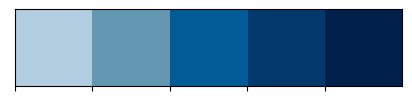

In [21]:
## Select the gradient color palette
palette = ['#b3cde0','#6497b1','#005b96','#03396c ','#011f4b']
colorScale = np.array(['#b3cde0','#6497b1','#005b96','#03396c','#011f4b'])
sns.palplot(sns.color_palette(colorScale))

In [22]:
def totalRecords_color(row):
    if row['totalRecords'] <= countyInterval[0]:
        return palette[0]
    elif row['totalRecords'] > countyInterval[0] and row['totalRecords'] <= countyInterval[1]:
        return palette[1]
    elif row['totalRecords'] > countyInterval[1] and row['totalRecords'] <= countyInterval[2]:
        return palette[2]
    elif row['totalRecords'] > countyInterval[2] and row['totalRecords'] <= countyInterval[3]:
        return palette[3]
    else:
        return palette[4]

## Append a new column with color generated above
df_group['Color'] = df_group.apply(totalRecords_color, axis=1)
df_group.head()

,countyCode,County,State,Title,sourceURL,btaaURL,totalRecords,Color
0,02b-17001,Adams County,Illinois,"[Adams County, Illinois GIS]",[https://www.adamscountygis.com],https://geo.btaa.org/?q=02b-17001,1,#b3cde0
1,06b-26005,Allegan County,Michigan,[Allegan County GIS Data Library],[https://www.allegancounty.org/online-services...,https://geo.btaa.org/?q=06b-26005,12,#6497b1
2,08b-42003,Allegheny County,Pennsylvania,[Allegheny County GIS Open Data],[https://openac-alcogis.opendata.arcgis.com],https://geo.btaa.org/?q=08b-42003,50,#6497b1
3,11b-39003,Allen County,Ohio,[Allen County GIS Data Download Page],[http://gis.allencountyohio.com/GIS/downloads....,https://geo.btaa.org/?q=11b-39003,12,#6497b1
4,04b-24003,Anne Arundel County,Maryland,[Anne Arundel County GIS Data],[https://maps.aacounty.org/],https://geo.btaa.org/?q=04b-24003,228,#005b96


### Merge county GeoJSON and geoportal GeoJSON

In [23]:
## Load countyjson featuer properties
county_geojson = gpd.read_file(countyjson)
county_json = json.loads(county_geojson.to_json())
df_allCounty = pd.json_normalize(county_json['features'])

## Change column names for further operation
df_allCounty = df_allCounty[['properties.County', 'properties.State', 'geometry.coordinates']].rename(
    columns={'properties.County':'County', 'properties.State':'State', 'geometry.coordinates':'boundingBox'})

df_allCounty.head()

,County,State,boundingBox
0,Chase County,Nebraska,"[[[-102.05, 40.7], [-102.05, 40.7], [-102.05, ..."
1,Dundy County,Nebraska,"[[[-101.32, 40.35], [-101.32, 40.35], [-101.33..."
2,Frontier County,Nebraska,"[[[-100.78, 40.7], [-100.78, 40.7], [-100.78, ..."
3,Furnas County,Nebraska,"[[[-100.09, 40.35], [-100.09, 40.35], [-100.1,..."
4,Gosper County,Nebraska,"[[[-99.98, 40.7], [-99.98, 40.7], [-99.98, 40...."


In [24]:
## Join on column 'County' and 'State' from left dataframe df_group
df_merge = pd.merge(df_group, df_allCounty, on = ['County','State'], how = 'left')
df_merge.head()

,countyCode,County,State,Title,sourceURL,btaaURL,totalRecords,Color,boundingBox
0,02b-17001,Adams County,Illinois,"[Adams County, Illinois GIS]",[https://www.adamscountygis.com],https://geo.btaa.org/?q=02b-17001,1,#b3cde0,"[[[-91.51, 40.2], [-91.51, 40.2], [-91.51, 40...."
1,06b-26005,Allegan County,Michigan,[Allegan County GIS Data Library],[https://www.allegancounty.org/online-services...,https://geo.btaa.org/?q=06b-26005,12,#6497b1,"[[[-86.21, 42.77], [-86.21, 42.77], [-86.21, 4..."
2,08b-42003,Allegheny County,Pennsylvania,[Allegheny County GIS Open Data],[https://openac-alcogis.opendata.arcgis.com],https://geo.btaa.org/?q=08b-42003,50,#6497b1,"[[[-80.15, 40.67], [-80.15, 40.67], [-80.15, 4..."
3,11b-39003,Allen County,Ohio,[Allen County GIS Data Download Page],[http://gis.allencountyohio.com/GIS/downloads....,https://geo.btaa.org/?q=11b-39003,12,#6497b1,"[[[-83.88, 40.92], [-83.88, 40.92], [-83.92, 4..."
4,04b-24003,Anne Arundel County,Maryland,[Anne Arundel County GIS Data],[https://maps.aacounty.org/],https://geo.btaa.org/?q=04b-24003,228,#005b96,"[[[[-76.5, 39.09], [-76.5, 39.09], [-76.5, 39...."


### Return rows with Nan value
Check if there exists any records doesn't include any coordinates information in the boundingBox column. <br>
If so, go back to `allCounties.csv` and manually change the **county** name to the one in `county.json`, then go to `Kernel` > `Restart & Run All`

In [25]:
def check_nanrows(df):
    if df.isnull().values.any():
        return df[df['boundingBox'].isnull()]
    else:
        print('> No NULL rows')        
check_nanrows(df_merge)

> No NULL rows


### Create county GeoJSON features

In [26]:
def create_geojson_features(df):
    print('> Creating county GeoJSON features...')
    features = []
    geometry_type = ''
    geojson = {
        'type': 'FeatureCollection',
        'features': features
    }
        
    for _, row in df.iterrows():
        if type(row['boundingBox'][0][0][0]) is float:
            geometry_type = 'Polygon'
        else:
            geometry_type = 'MultiPolygon'
            
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': geometry_type, 
                'coordinates': row['boundingBox']
            },
            'properties': {
                'County': row['County'],
                'State': row['State'],
                'countyCode': row['countyCode'],
                'Title': '|'.join([str(elem) for elem in row['Title']]),
                'sourceURL': '|'.join([str(elem) for elem in row['sourceURL']]), 
                'btaaURL': row['btaaURL'],
                'totalRecords': row['totalRecords'],
                'Color' : row['Color']
            }
           }

        features.append(feature)
    return geojson

data_geojson = create_geojson_features(df_merge)

> Creating county GeoJSON features...


### Write to county TopoJSON file `activeCounties.topo.json`

In [27]:
county_geojson = gpd.GeoDataFrame.from_features(data_geojson["features"])
# TopoJSON is an extension of GeoJSON to compress geometry information
topo = tp.Topology(county_geojson)
topo.to_json(activecounties)
print('> Creating county TopoJSON file...')

> Creating county TopoJSON file...


### Inspect county TopoJSON

In [28]:
topo.to_alt().properties(title='County Topology')

alt.Chart(...)

***

## Part 3: City Geoportals GeoJSON

### Format city name in city geoportals spreadsheet `allCities.csv`

In [29]:
df = pd.read_csv(citygeoportals)
## Calculate city coordinates and round to 2 decimal places 
df = pd.concat([df, df['Bounding Box'].str.split(',', expand=True).astype(float)], axis=1).rename(
    columns={0:'minX', 1:'minY', 2:'maxX', 3:'maxY'})
df['centerX'] = round((df['minX'] + df['maxX']) / 2, 2)
df['centerY'] = round((df['minY'] + df['maxY']) / 2, 2)
df_clean = df.drop(columns =['minX', 'minY', 'maxX', 'maxY', 'Bounding Box'])
df_clean.head()

,cityCode,City,State,Title,sourceURL,btaaURL,centerX,centerY
0,07c-02,Ann Arbor,Michigan,Ann Arbor Data Catalog,https://www.a2gov.org/services/data/Pages/defa...,https://geo.btaa.org/?q=07c-02,-83.74,42.27
1,11c-01-3,Cincinnati,Ohio,"ArcGIS REST Services Directory for Cincinnati,...",https://cagisonline.hamilton-co.org/arcgis/res...,https://geo.btaa.org/?q=11c-01-3,-84.54,39.17
2,11c-01-2,Cincinnati,Ohio,Cincinnati Area Geographic Information Systems...,http://cagis.org/Opendata/?,https://geo.btaa.org/?q=11c-01-2,-84.54,39.17
3,10c-02,Hudson,Wisconsin,"City Maps of Hudson, WI",https://hudsonwi.gov/475/City-Maps,https://geo.btaa.org/?q=10c-02,-92.73,44.96
4,04c-02,Baltimore,Maryland,City of Baltimore GIS Open Data,http://gis-baltimore.opendata.arcgis.com,https://geo.btaa.org/?q=04c-02,-76.62,39.28


### Etract total records number from BTAA Geoportal search page

In [30]:
df_clean['totalRecords'] = totalRecords(df_clean)

### Inspect the numinum number of total records
If it equals to 0, meaning the landing page is 404 Not Found. Go back to check if the identifier is still active. 

In [31]:
check_totalRecords(df_clean)

> State Geoportal Codes all valid!


### Group dataframe rows into list by geoportal sites

In [32]:
def aggregate_to_array(data):
    groupItems = ['Title', 'sourceURL', 'totalRecords']
    for i in range(len(groupItems)):
        data[groupItems[i]] = np.tile([data[groupItems[i]].values], (data.shape[0], 1)).tolist()
    return data

## Group by ['City', 'State']
df_group = df_clean.groupby(['centerX']).apply(aggregate_to_array).drop_duplicates(subset=['City', 'State'])
# sum up the total records if there're multiple geoportals in one city
df_group['totalRecords'] = df_group['totalRecords'].apply(lambda x: sum(int(item)for item in x))
df_group.head()

/var/folders/h1/wds8r6757dz_4h_l5tz85gyw0000gq/T/ipykernel_86130/890603058.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_group = df_clean.groupby(['centerX']).apply(aggregate_to_array).drop_duplicates(subset=['City', 'State'])


,cityCode,City,State,Title,sourceURL,btaaURL,centerX,centerY,totalRecords
0,07c-02,Ann Arbor,Michigan,[Ann Arbor Data Catalog],[https://www.a2gov.org/services/data/Pages/def...,https://geo.btaa.org/?q=07c-02,-83.74,42.27,43
1,11c-01-3,Cincinnati,Ohio,[ArcGIS REST Services Directory for Cincinnati...,[https://cagisonline.hamilton-co.org/arcgis/re...,https://geo.btaa.org/?q=11c-01-3,-84.54,39.17,5
3,10c-02,Hudson,Wisconsin,"[City Maps of Hudson, WI]",[https://hudsonwi.gov/475/City-Maps],https://geo.btaa.org/?q=10c-02,-92.73,44.96,52
4,04c-02,Baltimore,Maryland,"[City of Baltimore GIS Open Data, Open Baltimore]","[http://gis-baltimore.opendata.arcgis.com, htt...",https://geo.btaa.org/?q=04c-02,-76.62,39.28,1551
5,01c-01,Bloomington,Indiana,"[City of Bloomington, Indiana Open Data Portal]",[https://data.bloomington.in.gov],https://geo.btaa.org/?q=01c-01,-86.53,39.17,28


### Classify the geoportal by total number
You may want to adjust the classification method **`Quantiles`** and class number **`k`**. 
Reference the <a href="https://pypi.org/project/mapclassify/">mapclassify</a>.

In [33]:
n3 = mapclassify.Quantiles(df_group.totalRecords, k=3)
n3

Quantiles                 

     Interval        Count
--------------------------
[   3.00,   35.67] |     8
(  35.67,  110.00] |     7
( 110.00, 1551.00] |     8

In [34]:
cityInterval = list(n3.bins)

### Assign different circle radius to each geoportal based on total records class

In [35]:
## Size of symbols on map in meters 
size = [12000, 16000, 22000]
## Size of symbols inside legend in pixels
legendSize = [12, 18, 28]

In [36]:
def totalRecords_size(row):
    if row['totalRecords'] <= cityInterval[0]:
        return size[0]
    elif row['totalRecords'] > cityInterval[0] and row['totalRecords'] <= cityInterval[1]:
        return size[1]
    else:
        return size[2]

## Append a new column with color generated above
df_group['Size'] = df_group.apply(totalRecords_size, axis=1)
df_group.head()

,cityCode,City,State,Title,sourceURL,btaaURL,centerX,centerY,totalRecords,Size
0,07c-02,Ann Arbor,Michigan,[Ann Arbor Data Catalog],[https://www.a2gov.org/services/data/Pages/def...,https://geo.btaa.org/?q=07c-02,-83.74,42.27,43,16000
1,11c-01-3,Cincinnati,Ohio,[ArcGIS REST Services Directory for Cincinnati...,[https://cagisonline.hamilton-co.org/arcgis/re...,https://geo.btaa.org/?q=11c-01-3,-84.54,39.17,5,12000
3,10c-02,Hudson,Wisconsin,"[City Maps of Hudson, WI]",[https://hudsonwi.gov/475/City-Maps],https://geo.btaa.org/?q=10c-02,-92.73,44.96,52,16000
4,04c-02,Baltimore,Maryland,"[City of Baltimore GIS Open Data, Open Baltimore]","[http://gis-baltimore.opendata.arcgis.com, htt...",https://geo.btaa.org/?q=04c-02,-76.62,39.28,1551,22000
5,01c-01,Bloomington,Indiana,"[City of Bloomington, Indiana Open Data Portal]",[https://data.bloomington.in.gov],https://geo.btaa.org/?q=01c-01,-86.53,39.17,28,12000


### Create city GeoJSON features

In [37]:
def create_geojson_features(df):
    print('> Creating city GeoJSON features...')
    features = []
    geojson = {
        'type': 'FeatureCollection',
        'features': features
    }
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['centerX'], row['centerY']]
            },
            'properties': {
                'City': row['City'],
                'State': row['State'],
                'Title': '|'.join([str(elem) for elem in row['Title']]),
                'sourceURL': '|'.join([str(elem) for elem in row['sourceURL']]), 
                'btaaURL': row['btaaURL'],
                'totalRecords': row['totalRecords'],
                'Size' : row['Size']
            }
           }

        features.append(feature)
    return geojson

data_geojson = create_geojson_features(df_group)

> Creating city GeoJSON features...


### Write to city GeoJSON file `activecities.json`

In [38]:
with open(activecities, 'w') as txtfile:
    json.dump(data_geojson, txtfile)
print('> Creating city GeoJSON file...')

> Creating city GeoJSON file...


### Inspect city GeoJSON

In [39]:
print('> Making map...')
m = folium.Map(location = [44, -90], control_scale = True, zoom_start = 6)

lyrCity = folium.GeoJson(open(activecities, 'r').read(),
               tooltip = folium.GeoJsonTooltip(fields=('City', 'sourceURL'),
                                               aliases=('city','websiteUrl')),
               show = True).add_to(m)
m

> Making map...


***

## Part 4: Legend JSON

### Create legend JSON features

In [40]:
def create_legend_json(countyinterval, palette, cityinterval, size):
    print('> Creating legend JSON featuers...')
    countystyle = dict(zip(countyinterval, palette))
    citystyle = dict(zip(cityinterval, size))
    dic = {
            'county':countystyle,
              'city':citystyle
          }
    return dic
    
data_json = create_legend_json(countyInterval, palette, cityInterval, legendSize)

> Creating legend JSON featuers...


### Write to legend JSON file `legend.json`

In [41]:
with open(legendjson, 'w') as txtfile:
    json.dump(data_json, txtfile)
print('> Creating legend JSON file...')

> Creating legend JSON file...
